In [1]:
# Cài đặt thư viện Python
!pip install torch torchvision timm transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [1]:
import os
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values


/home/sakana/anaconda3/envs/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "5CD-AI/Vintern-1B-v3_5"

try:
  model = AutoModel.from_pretrained(
      model_name,
      dtype=torch.bfloat16,
      low_cpu_mem_usage=True,
      trust_remote_code=True,
      use_flash_attn=False,
  ).eval().cuda()
except:
  model = AutoModel.from_pretrained(
      model_name,
      dtype=torch.bfloat16,
      low_cpu_mem_usage=True,
      trust_remote_code=True
  ).eval().cuda()

  tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)


/home/sakana/anaconda3/envs/venv/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


FlashAttention2 is not installed.


In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)

In [4]:
import requests

def download_image_with_headers(image_url, save_path):
    """Downloads an image from a URL by faking a User-Agent header."""
    # A standard User-Agent header from a web browser
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36'
    }

    try:
        # Send a GET request with the custom headers
        response = requests.get(image_url, headers=headers, stream=True)
        response.raise_for_status()  # Raise an exception for bad status codes

        # Open the file in binary write mode ('wb') and save the image content
        with open(save_path, 'wb') as f:
            for chunk in response.iter_content(1024):
                f.write(chunk)
        print(f"Image successfully downloaded to {save_path}")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")

# The image URL that returned the 403 error
image_url = "https://cdn.imgchest.com/files/6eabda6b2999.png"
save_location = "downloaded_image.png"

# Call the function to download the image with the fake User-Agent
download_image_with_headers(image_url, save_location)

Image successfully downloaded to downloaded_image.png


In [11]:
!ls

downloaded_image.png  state.db


In [6]:
!pip install matplotlib

  Using cached contourpy-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 8.5 MB/s  0:00:018.2 MB/s eta 0:00:01:01
Using cached contourpy-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (325 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 14.9 MB/s  0:00:004.6 MB/s eta 0:00:01
Using cached kiwisolver-1.4.9-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib] 5/6 [matplotlib]


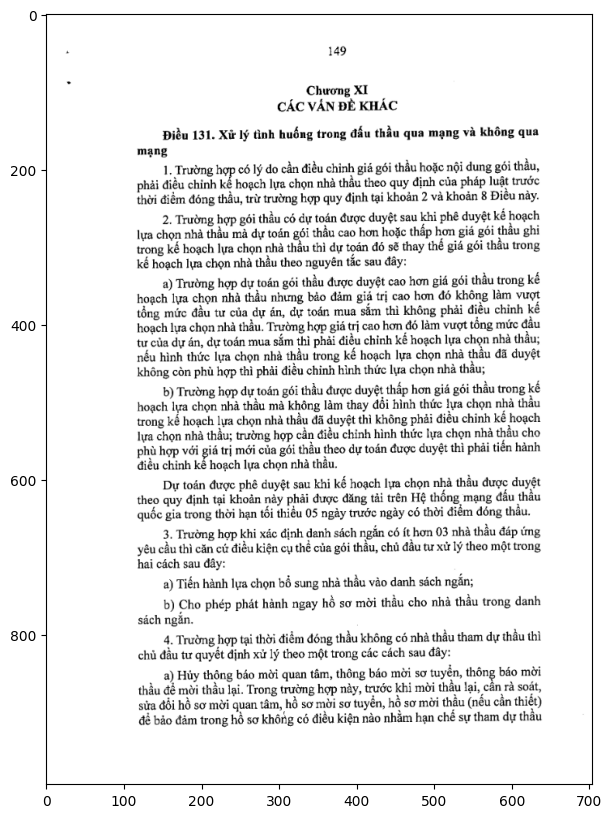

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Hãy trích xuất TOÀN BỘ văn bản trong ảnh theo đúng thứ tự đọc. Chỉ trả về **văn bản thuần** (plain text), giữ nguyên xuống dòng, không thêm lời giải thích hay ký hiệu lạ.
Assistant: Điều 131. Xử lý tình huống trong đấu thầu qua mạng và không qua mạng

1. Trường hợp có lý do cần điều chỉnh giá gói thầu hoặc nội dung gói thầu, phải điều chỉnh kế hoạch lựa chọn nhà thầu theo quy định của pháp luật trước thời điểm đóng thầu, trừ trường hợp quy định tại khoản 2 và khoản 8 Điều này.

2. Trường hợp gói thầu có dự toán được duyệt sau khi phê duyệt kế hoạch lựa chọn nhà thầu mà dự toán gói thầu cao hơn hoặc thấp hơn giá gói thầu ghi trong kế hoạch lựa chọn nhà thầu thì dự toán đó sẽ thay thế giá gói thầu trong kế hoạch lựa chọn nhà thầu theo nguyên tắc sau đây:

a) Trường hợp dự toán gói thầu được duyệt cao hơn giá gói thầu trong kế hoạch lựa chọn nhà thầu nhưng bảo đảm giá trị cao hơn đó không làm vượt tổng mức đầu tư của dự án, dự toán mua sắm thì không phải điều chỉnh kế hoạch 

In [8]:
import matplotlib.pyplot as plt
test_image = "./downloaded_image.png"
plt.figure(figsize=(10,10))
plt.imshow(Image.open(test_image))
plt.show()
pixel_values = load_image(test_image, max_num=6).to(torch.bfloat16).cuda()
generation_config = dict(max_new_tokens= 2048, do_sample=False, num_beams = 3, repetition_penalty=3.5)

prompt = (
        "<image>\nHãy trích xuất TOÀN BỘ văn bản trong ảnh theo đúng thứ tự đọc. "
        "Chỉ trả về **văn bản thuần** (plain text), giữ nguyên xuống dòng, "
        "không thêm lời giải thích hay ký hiệu lạ."
    )

response = model.chat(tokenizer, pixel_values, prompt, generation_config)
print(f'User: {prompt}\nAssistant: {response}')
